In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as colors

from babel.numbers import get_territory_currencies

In [3]:
df_games_prices = pd.read_excel("../Data/list_1_processed_old.xlsx", index_col="Unnamed: 0")

# Data Exploration

Average difference between most expensive top 10 and cheapest top 10

In [4]:
lowest_prices_avg = df_games_prices.describe().loc["mean"].sort_values(ascending=False).tail(10).mean()
higest_prices_avg = df_games_prices.describe().loc["mean"].sort_values(ascending=True).tail(10).mean()
cheap_price_perc_dif = (lowest_prices_avg/higest_prices_avg) - 1
f"{cheap_price_perc_dif:0.2f}%", f"{cheap_price_perc_dif*higest_prices_avg:0.2f} USD"

('-0.50%', '-14.83 USD')

Average difference between US steam games' prices and the worlds' average

In [5]:
us_games_price_avg = df_games_prices.describe().loc["mean"]["us"]
world_prices_avg = df_games_prices.describe().loc["mean"].mean()

us_price_perc_dif = (us_games_price_avg/world_prices_avg) - 1
f"{us_price_perc_dif:0.2f}%", f"{us_price_perc_dif*world_prices_avg:0.2f} USD"

('0.30%', '6.71 USD')

Average difference between Argentina steam games' prices and the worlds' average

In [6]:
arg_games_price_avg = df_games_prices.describe().loc["mean"]["ar"]
world_prices_avg = df_games_prices.describe().loc["mean"].mean()

us_price_perc_dif = (arg_games_price_avg/world_prices_avg) - 1
f"{us_price_perc_dif:0.2f}%", f"{us_price_perc_dif*world_prices_avg:0.2f} USD"

('-0.53%', '-11.85 USD')

Average difference between each country's price and worlds' average

<AxesSubplot:>

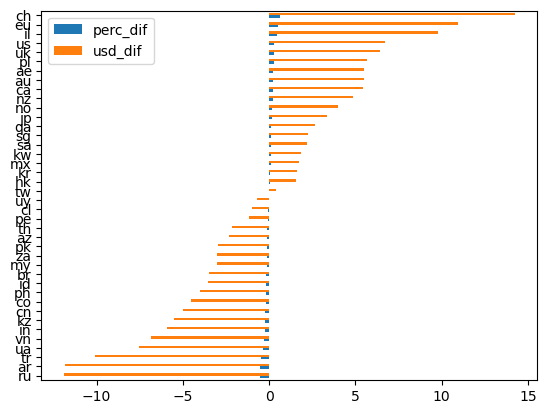

In [7]:
world_prices_avg = df_games_prices.describe().loc["mean"].mean()
world_prices_avg_perc_dif = (df_games_prices.describe().loc["mean"]/world_prices_avg) - 1
world_prices_avg_perc_dif.name = "perc_dif"
world_prices_avg_usd_dif = world_prices_avg_perc_dif * world_prices_avg
world_prices_avg_usd_dif.name = "usd_dif"

world_prices_df = pd.DataFrame([world_prices_avg_perc_dif, world_prices_avg_usd_dif]).T
world_prices_df.sort_values(by="usd_dif").plot(kind="barh")

# Data Processing

In [8]:
world_prices_df = world_prices_df.reset_index()

let's change GB for UK for England

In [9]:
uk_data_point_index = world_prices_df[world_prices_df["index"].str.lower() == "uk"].index
world_prices_df.loc[uk_data_point_index,("index")] = "GB"

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# create a lookup table to map iso_2_codes and iso_3_codes
iso_lookup = pd.read_csv('https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv', usecols=['alpha-3', 'alpha-2'])
iso_lookup = iso_lookup.set_index('alpha-3')

# add a new column with iso_a2 codes to the world GeoDataFrame
world['iso_a2'] = world['iso_a3'].apply(lambda x: iso_lookup.loc[x]['alpha-2'] if x in iso_lookup.index else None)

# obtain countries with euro as their currency
european_countries_iso_codes = world[world["continent"] == "Europe"]["iso_a2"]
euro_countries = []
for i,country_iso_code in european_countries_iso_codes.items():
    if country_iso_code:
        euro_country = get_territory_currencies(country_iso_code)
        if euro_country[0].lower() == "eur":
            euro_countries.append(country_iso_code.lower())

# change euro countries' iso_2 code to EU so that they can be joined with the world_prices_df
world["iso_a2"] = world["iso_a2"][~world["iso_a2"].isna()].apply(lambda country_code: "EU" if country_code.lower() in euro_countries else country_code)

world_prices_df["index"] = world_prices_df["index"].str.upper()
merged = world.merge(world_prices_df, left_on='iso_a2', right_on='index')
merged

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,iso_a2,index,perc_dif,usd_dif
0,3.758926e+07,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CA,CA,0.245295,5.453155
1,3.282395e+08,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",US,US,0.302040,6.714654
2,1.851393e+07,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",KZ,KZ,-0.247050,-5.492157
3,2.706256e+08,Asia,Indonesia,IDN,1119190,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...",ID,ID,-0.159479,-3.545383
4,4.493871e+07,South America,Argentina,ARG,445445,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",AR,AR,-0.533200,-11.853570
5,1.895204e+07,South America,Chile,CHL,282318,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...",CL,CL,-0.043499,-0.967026
6,1.443735e+08,Europe,Russia,RUS,1699876,"MULTIPOLYGON (((180.00000 71.51571, 180.00000 ...",RU,RU,-0.534887,-11.891057
7,5.347896e+06,Europe,Norway,NOR,403336,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...",NO,NO,0.178509,3.968440
8,5.855827e+07,Africa,South Africa,ZAF,351431,"POLYGON ((16.34498 -28.57671, 16.82402 -28.082...",ZA,ZA,-0.136243,-3.028825
9,1.275755e+08,North America,Mexico,MEX,1268870,"POLYGON ((-117.12776 32.53534, -115.99135 32.6...",MX,MX,0.077381,1.720246


Let's create a dataframe with the world data, but with 0 as steam price value so that missing country data is displayed as gray (the relevant data will be displayed on top of this)

In [11]:
missing_countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
missing_countries["steam_value"] = 0
missing_countries

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,steam_value
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",0
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0
...,...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",0
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",0
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",0
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",0


We create a color map for green as low value (cheapest steam price value) and red as high value

In [12]:
# Create a custom colormap that ranges from green to red
cmap = colors.LinearSegmentedColormap.from_list('green_to_red', [(0, 'green'), (1, 'red')])

# Normalize the data using vmin and vmax
norm = colors.Normalize(vmin=merged["usd_dif"].min(), vmax=merged["usd_dif"].max())

The world map is created using all the data obtained above

C:\Users\Edsel Di Meo\AppData\Roaming\Python\Python39\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


Text(0.5, 1.0, 'Steam prices relative to world average in USD')

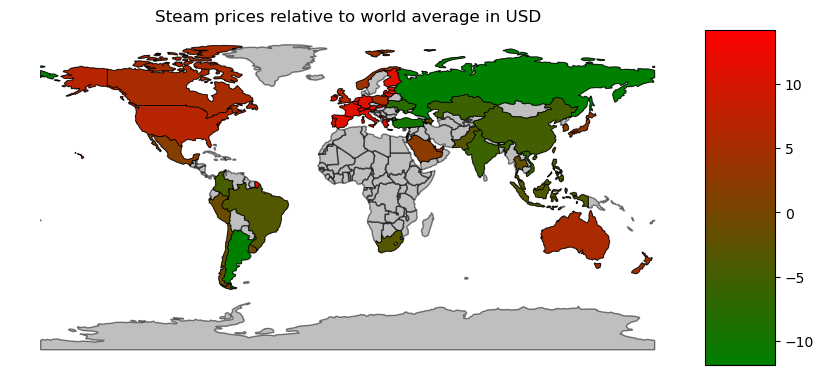

In [13]:
# Create a large plot
fig, ax = plt.subplots(figsize=(10, 8))

from mpl_toolkits.axes_grid1 import make_axes_locatable

# We make the legend as small and thin as possible
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)

# we display the missing country data and the countries with data will be overriden by the merged plot
missing_countries.plot(column="steam_value",ax=ax, color="gray", linestyle='-', edgecolor='black', alpha=0.5)
merged.plot(column='usd_dif', ax=ax, cmap=cmap, norm=norm, cax=cax, linewidth=0.5, linestyle='-', edgecolor='black', legend=True)
ax.set_axis_off()
ax.set_title("Steam prices relative to world average in USD")